Lambda School Data Science

*Unit 2, Sprint 2, Module 2*

---

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/main/data/'
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

# Module Project: Random Forests

This week, the module projects will focus on creating and improving a model for the Tanazania Water Pump datset. Your goal is to create a model to predict whether a water pump is functional, non-functional, or needs repair.

Dataset source: [DrivenData.org](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/).

## Directions

The tasks for this project are as follows:

- **Task 1:** Sign up for a [Kaggle](https://www.kaggle.com/) account.
- **Task 2:** Use `wrangle` function to import training and test data.
- **Task 3:** Split training data into feature matrix `X` and target vector `y`.
- **Task 4:** Split feature matrix `X` and target vector `y` into training and test sets.
- **Task 5:** Establish the baseline accuracy score for your dataset.
- **Task 6:** Build and train `model_dt`.
- **Task 7:** Calculate the training and validation accuracy score for your model.
- **Task 8:** Adjust model's `max_depth` to reduce overfitting.
- **Task 9 `stretch goal`:** Create a horizontal bar chart showing the 10 most important features for your model.

You should limit yourself to the following libraries for this project:

- `category_encoders`
- `matplotlib`
- `pandas`
- `pandas-profiling`
- `sklearn`

# I. Wrangle Data

In [2]:
def wrangle(fm_path, tv_path=None):
    if tv_path:
        df = pd.merge(pd.read_csv(fm_path, 
                                  na_values=[0, -2.000000e-08],
                                parse_dates=['date_recorded']),
                      pd.read_csv(tv_path)).set_index('id')
    else:
        df = pd.read_csv(fm_path, 
                         na_values=[0, -2.000000e-08],
                         parse_dates=['date_recorded'],
                         index_col='id')
    
    # feature engineer 'pump_age'
    df['pump_age'] = df['date_recorded'].dt.year - df['construction_year']
    df.drop(columns=['date_recorded'], inplace=True)
    # Drop constant columns
    df.drop(columns=['recorded_by'], inplace=True)

    # Drop HCCCs
    cutoff = 100
    drop_cols = [col for col in df.select_dtypes('object').columns
                 if df[col].nunique() > cutoff]
    df.drop(columns=drop_cols, inplace=True)

    # Drop duplicate columns
    dupe_cols = [col for col in df.head(15).T.duplicated().index
                 if df.head(15).T.duplicated()[col]]
    df.drop(columns=dupe_cols, inplace=True)          

    return df

**Task 1:** Sign up for a [Kaggle](https://www.kaggle.com/) account. Choose a username that's based on your real name. Like GitHub, Kaggle is part of your public profile as a data scientist.

**Task 2:** Modify the `wrangle` function to engineer a `'pump_age'` feature. Then use the function to read `train_features.csv` and `train_labels.csv` into the DataFrame `df`, and `test_features.csv` into the DataFrame `X_test`.

In [3]:
import pandas as pd
df = wrangle('../data/waterpumps/train_features.csv' , '../data/waterpumps/train_labels.csv')
X_test = wrangle('../data/waterpumps/test_features.csv')

display(df.head())
display(df.info())

,amount_tsh,gps_height,longitude,latitude,num_private,basin,region,region_code,district_code,population,...,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,pump_age
id,,,,,,,,,,,,,,,,,,,,,
69572.0,6000.0,1390.0,34.938093,-9.856322,NaN,Lake Nyasa,Iringa,11,5.0,109.0,...,soft,good,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional,12.0
8776.0,NaN,1399.0,34.698766,-2.147466,NaN,Lake Victoria,Mara,20,2.0,280.0,...,soft,good,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,3.0
34310.0,25.0,686.0,37.460664,-3.821329,NaN,Pangani,Manyara,21,4.0,250.0,...,soft,good,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional,4.0
67743.0,NaN,263.0,38.486161,-11.155298,NaN,Ruvuma / Southern Coast,Mtwara,90,63.0,58.0,...,soft,good,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional,27.0
19728.0,NaN,NaN,31.130847,-1.825359,NaN,Lake Victoria,Kagera,18,1.0,NaN,...,soft,good,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,NaN


<class 'pandas.core.frame.DataFrame'>
Float64Index: 59399 entries, 69572.0 to 26348.0
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             17761 non-null  float64
 1   gps_height             38962 non-null  float64
 2   longitude              57587 non-null  float64
 3   latitude               57587 non-null  float64
 4   num_private            757 non-null    float64
 5   basin                  59399 non-null  object 
 6   region                 59399 non-null  object 
 7   region_code            59399 non-null  int64  
 8   district_code          59376 non-null  float64
 9   population             38019 non-null  float64
 10  public_meeting         56066 non-null  object 
 11  scheme_management      55522 non-null  object 
 12  permit                 56343 non-null  object 
 13  construction_year      38691 non-null  float64
 14  extraction_type        59399 non-null  objec

None

# II. Split Data

**Task 3:** Split your DataFrame `df` into a feature matrix `X` and the target vector `y`. You want to predict `'status_group'`.

In [4]:
target = 'status_group'
X = df.drop(columns=target)
y = df[target]

**Task 4:** Using a randomized split, divide `X` and `y` into a training set (`X_train`, `y_train`) and a validation set (`X_val`, `y_val`).

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# III. Establish Baseline

**Task 5:** Since this is a **classification** problem, you should establish a baseline accuracy score. Figure out what is the majority class in `y_train` and what percentage of your training observations it represents.

In [6]:
baseline_acc = y_train.value_counts(normalize=True).max()
print('Baseline Accuracy Score:', baseline_acc)

Baseline Accuracy Score: 0.5425829668132747


# IV. Build Model

**Task 6:** Build a `Pipeline` named `model_rf`, and fit it to your training data. Your `Pipeline` should include:

- an `OrdinalEncoder` transformer for categorical features.
- a `SimpleImputer` transformer fot missing values.
- a `RandomForestClassifier` predictor.

**Note:** Don't forget to set the `random_state` parameter for your `RandomForestClassifier`. Also, to decrease training time, set `n_jobs` to `-1`.

In [26]:
from sklearn.pipeline import make_pipeline
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier

model_rf = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
)
model_rf.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['basin', 'region', 'public_meeting',
                                      'scheme_management', 'permit',
                                      'extraction_type',
                                      'extraction_type_class', 'management',
                                      'management_group', 'payment',
                                      'payment_type', 'water_quality',
                                      'quality_group', 'quantity', 'source',
                                      'source_type', 'source_class',
                                      'waterpoint_type',
                                      'waterpoint_type_group'],
                                mapping=[...
hand pump                      2
other                          3
communal standpipe multiple    4
improved spring                5
cattle trough                  6
dam                            7
NaN                           -2
dtyp

# V. Check Metrics

**Task 7:** Calculate the training and validation accuracy scores for `model_rf`.

In [27]:
training_acc = model_rf.score(X_train, y_train)
val_acc = model_rf.score(X_val, y_val)

print('Training Accuracy Score:', training_acc)
print('Validation Accuracy Score:', val_acc)

Training Accuracy Score: 0.9952440076600939
Validation Accuracy Score: 0.8022727272727272


# VI. Tune Model

**Task 8:** Tune `n_estimators` and `max_depth` hyperparameters for your `RandomForestClassifier` to get the best validation accuracy score for `model_rf`. 

In [28]:
# Use this cell to experiment and then change 
# your model hyperparameters in Task 6
model_rf = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    RandomForestClassifier(
        n_estimators=100,
        n_jobs=-1,
        random_state=42,
        max_depth=17
    )
)
model_rf.fit(X_train, y_train)
training_acc = model_rf.score(X_train, y_train)
val_acc = model_rf.score(X_val, y_val)
print('Training Accuracy Score:', training_acc)
print('Validation Accuracy Score:', val_acc)

Training Accuracy Score: 0.8982301816115659
Validation Accuracy Score: 0.8032828282828283


In [29]:
depths = range(2, 30)
train_acc = []
val_acc = []
for depth in depths:
    model_rf = make_pipeline(
        OrdinalEncoder(),
        SimpleImputer(strategy='mean'),
        RandomForestClassifier(
            n_estimators=100,
            n_jobs=-1,
            random_state=42,
            max_depth=depth
        )
    )
    model_rf.fit(X_train, y_train)
    train_acc.append(model_rf.score(X_train, y_train))
    val_acc.append(model_rf.score(X_val, y_val))
print(val_acc.index(max(val_acc)))

17


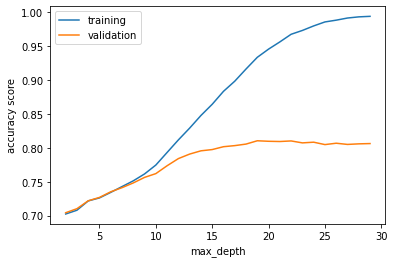

In [30]:
import matplotlib.pyplot as plt
plt.plot(depths, train_acc, label='training')
plt.plot(depths, val_acc, label='validation')
plt.xlabel('max_depth')
plt.ylabel('accuracy score')
plt.legend()
plt.show()

In [37]:
import numpy as np

# samples = np.arange(0.2, 1, 0.1)
features = np.arange(0.2, 1, 0.1)

train_acc = []
val_acc = []
for feature in features:
    rf_model = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    RandomForestClassifier(n_estimators=25,
                           n_jobs=-1,
                           random_state=42,
                           max_features=feature)
    )
    model_rf.fit(X_train, y_train)
    
    train_acc.append(model_rf.score(X_train, y_train))
    val_acc.append(model_rf.score(X_val, y_val))

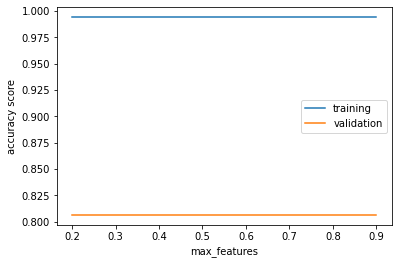

In [38]:
plt.plot(features, train_acc, label='training')
plt.plot(features, val_acc, label='validation')
plt.xlabel('max_features')
plt.ylabel('accuracy score')
plt.legend()
plt.show()

# VII. Communicate Results

**Task 9:** Generate a list of predictions for `X_test`. The list should be named `y_pred`.

In [50]:
y_pred = model_rf.predict(X_test)
display(y_pred[:10])
assert len(y_pred) == len(X_test), f'Your list of predictions should have {len(X_test)} items in it. '

array(['non functional', 'functional', 'functional', 'non functional',
       'functional', 'functional', 'non functional', 'non functional',
       'non functional', 'functional'], dtype=object)

**Task 11 `stretch goal`:** Create a DataFrame `submission` whose index is the same as `X_test` and that has one column `'status_group'` with your predictions. Next, save this DataFrame as a CSV file and upload your submissions to our competition site. 

**Note:** Check the `sample_submission.csv` file on the competition website to make sure your submissions follows the same formatting. 

In [ ]:
submission = ...